## Experiment log:
- First, we took only the tweet text, without keywords or locations, and tried a simple model with an embedding layer, followed by a mean layer, then the output layers. Stopwords were not removed and no stemming was performed. Accuracy was varying between runs, ranging between 0.625 0.96875. We can do better.
- Next,we tried removing stopwords. Accuracy did not peak as high as it was before, but the variance was less. Acuracy ranged between 0.46875 and 0.8125.
- We tried stemming alone. Same as removing stopwords. Acuracy ranged between 0.5 and 0.8125.
- Both stemming and removing stopwords made the training smoother, with the accuracy less fluctuating and almost steadily increasing. Range was between 0.46875 and 0.75.
- After looking at kewyords, they seem helpful. They are the one or few words that are the main focus of the tweet. We could use that.
- We tried just appending the keywords at the end of the original tweets, althought they are there anyway. We thought that would help the model pay more attention to the keyword and that would help capturing the sentiment of the tweet. It could have done that, but we did not see any significant increase in accuracy, it was between 0.5 and 0.8125. We need to think of another way to include them.
-  Next, we tried an Embedding, LSTM, Fn (select_last), Dense (output), LogSoftmax/Sigmoid/Relu architecture. It was terrible! The accuracy was 0.5 most of the time, and even dropped to 0.40625 briefly. 
- We tried then to be creative :D we created two branches of Embedding, Mean, Dense, and LogSoftmax, one to process the tweet text and the other to process the keyword alone, then we averaged the log-softmax scores. The results were much better! The accuracy peaked at 1.0 briefly. We then did some tweaking of the learning rate and number of iterations not just to get higher accuracy but also to make it more steady and consistent.
- Locations seemed interesting, I tried looking up location values in a third party repository for geolocation data. We were particularly interested in longitude and latitude. I got that, converted long/lat to spherical coordinates, fed that to a third branch in the model, and averaged the scores. The results were terrible! The model accuracy struggled to stay between mid 50s and mid 40s. It even dropped below that range. I tried adding another hidden layer between the input and output layers in that branch but that did not help. The problem I could see is that there were multiple suggestions for so many locations. I tried choosing one at random and choosing the first one, but neither helped. Also, imputing missing location values with 0s for lon and lat could have made things worse, because that's an actual geographical location that the model tried to relate to disasters.
- I tried reading location like I read text and keyword and using the vocabulary to transform it into a a tensor, and run it through yet another branch. Results were better that the geolcation data not really impressive.
- Next thing to try was to concatenate keywords and locations to the text with separators in between, and use the original architecture with Embedding, Mean, Dense, and LogSoftmax layers. It worked. Average accuracy was 0.691
- I really wanted to make this better, I added key word to location and fed it to a separate branch, and the tweet body to the other branch, we could squeeze a few more hundredths of degrees of accuracy and F1 scores, average accuracy was   
- Eureka! Transfer learning. I downloaded Glove pre-trained word-embedding, and intilaized the embedding layer with those weights and shared it between the two branches. Because the layer is trainable, the weights were overwritten during the training process. We need to lock it down and make it non-trainable. The problem is that Trax does not have such layer, we will have to rig something up.
- I tried to overload backward() and has_backward in a custom Embedding layer to make it untrainable but it does not seem to work. The best we could achive so far was training an embedding layer in two branches one for the tweet body and the other for the keyword + location

In [45]:
import os
import re
import shutil
import string
import random
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import trax.fastmath.numpy as np
from trax import layers as tl
from trax import optimizers
from trax.supervised import training

%matplotlib inline

In [46]:
import trax
import gzip
import pickle
import enchant

## Loading tweets

In [47]:
VAL_PCT = 0.2
MODEL_DIR = './model'
OUTPUT_DIR = './output'
stopwords_english = stopwords.words('english')
dict_english = enchant.Dict('en_US')

In [48]:
RAW_EMBED_FILE = '../../data/glove.twitter.27B.200d.txt'
PROC_EMBED_FILE = f'{OUTPUT_DIR}/embeddings.pkl.gz'


def parse_n_save_embeds(raw_embed_file, proc_embed_file):
    embeds = {}
    with open(raw_embed_file) as emf:
        for line in emf:
            tokens = line.split()
            word = tokens[0].lower()
            embed = [float(token) for token in tokens[1:]]
            if dict_english.check(word):
                if len(embed) == 200:
                    embeds[word] = embed
                else:
                    print(f'>>> Word {word} has {len(embed)} size embedding! Ignoring.')
                    
    embed_matrix = np.array(list(embeds.values()), 'float32')
        
    word_idx = {w:i for i, w in enumerate(embeds.keys())}
    word_idx['__unk__'] = len(word_idx)
    word_idx['__pad__'] = len(word_idx)
    
    output = {
        'flat_weights': [embed_matrix],
        'flat_state': [], # Required later when initializing layer
        'word_index': word_idx,
    }
    with gzip.open(proc_embed_file, 'wb') as ef:
        pickle.dump(output, ef, protocol=pickle.HIGHEST_PROTOCOL)
        
    return embed_matrix, word_idx
        

def load_embeds(proc_embed_file):
    with gzip.open(proc_embed_file, 'rb') as ef:
        embeds = pickle.load(ef)

    embed_matrix = embeds['flat_weights']
    word_index = embeds['word_index']
    
    return embed_matrix, word_index

# EMBED_MATRIX, WORD_IDX = parse_n_save_embeds(RAW_EMBED_FILE, PROC_EMBED_FILE)
# EMBED_MATRIX, WORD_IDX = load_embeds(PROC_EMBED_FILE)

# EMBED_SIZE = len(EMBED_MATRIX[0][0])
# print(f'>>> {len(EMBED_MATRIX[0])} word embeddings, each of size {EMBED_SIZE}')

# IDX_WORD = {i:w for w, i in WORD_IDX.items()}

# del EMBED_MATRIX

In [49]:
all_train_tweets = pd.read_csv('data/train.csv')
all_test_tweets = pd.read_csv('data/test.csv')

In [50]:
all_train_tweets.loc[all_train_tweets.target == 1].head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [51]:
all_train_tweets.loc[all_train_tweets.target == 0].head()

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0


In [52]:
all_train_tweets.location.loc[~all_train_tweets.location.isna()].head()

31                       Birmingham
32    Est. September 2012 - Bristol
33                           AFRICA
34                 Philadelphia, PA
35                       London, UK
Name: location, dtype: object

In [53]:
all_train_tweets.keyword.loc[~all_train_tweets.keyword.isna()].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [54]:
# That is how the tweets looked like when we tried appending the keywords
(all_train_tweets.text + ' ' + all_train_tweets.keyword.fillna('')).loc[~all_train_tweets.keyword.isna()].to_list()[:5]

['@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C ablaze',
 'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw ablaze',
 '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi ablaze',
 'Crying out for more! Set me ablaze ablaze',
 'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N ablaze']

In [55]:
# Location seems useful. Very messy, though.
all_train_tweets.location.loc[~all_train_tweets.location.isna()].sort_values()

6771                          
7571                  Glasgow 
1797      Melbourne, Australia
2752                      News
3757                       å_ 
                 ...          
4165           å_: ?? ÌÑ ? : ?
6834      å_å_Los Mina Cityã¢
6989        å¡å¡Midwest Û¢Û¢
7183         åÊ(?Û¢`?Û¢å«)??
2419               åø\_(?)_/åø
Name: location, Length: 5080, dtype: object

## Preprocessing

In [56]:
def process_tweet(tweet, remove_stopwords=False, stem=False):
    if tweet:
        # Remove hyper-links
        tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
        # Remove hashtags
        tweet = re.sub(r'#', '', tweet)
        # Remove stock market tickers
        tweet = re.sub(r'\$\w*', '', tweet)
        # Remove old style tweet text RT
        tweet = re.sub(r'^RT[\s]+', '', tweet)
        # Tokenize tweet
        tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
        tweet = [word for word in tokenizer.tokenize(tweet) if word not in string.punctuation]
        if remove_stopwords:
            tweet = [word for word in tweet if word not in stopwords_english]
        if stem:
            stemmer = PorterStemmer()
            tweet = [stemmer.stem(word) for word in tweet]
    else:
        tweet = ['__NA__']

    return tweet

In [57]:
def process_location(loc):
    if loc:
        tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
        loc = [word for word in tokenizer.tokenize(loc) if word not in string.punctuation]
    else:
        loc = ['__NA__']

    return loc

In [58]:
def clean_dataset(dataset_df):
    dataset_df['text_clean'] = dataset_df.text.apply(process_tweet, args=(True, False))
    dataset_df['keyword_clean'] = dataset_df.keyword.fillna('').apply(process_tweet, args=(True, False))
    dataset_df['location_clean'] = dataset_df.location.fillna('').apply(process_location)
    
clean_dataset(all_train_tweets)
clean_dataset(all_test_tweets)

In [59]:
# The purpose of this is to show how long the sequences we are dealing with.
# The longer the sequence, the tricker it is to capture the whole meaning of the tweet.
all_train_tweets.text_clean.map(lambda t: len(t)).quantile([0.0, 0.25, .50, 0.75, 1.0])

0.00     0.0
0.25     6.0
0.50     9.0
0.75    12.0
1.00    26.0
Name: text_clean, dtype: float64

In [60]:
# Building vocabulary
def build_vocab(tweets):
    vocab = {
        '__pad__': 0,
        '__unk__': 2,
    }
    for tweet in tweets:
        for word in tweet:
            if word not in vocab:
                vocab[word] = len(vocab)
    return vocab


# Tweet to tensor
def tweet_to_tensor(tweet, vocab):
    tweet = [vocab.get(token, vocab['__unk__']) for token in tweet]
    return tweet


def prep_dataset(dataset_df, vocab):
    dataset_df['text_clean'] = dataset_df.text_clean.apply(tweet_to_tensor, args=(vocab,))
    dataset_df['keyword_clean'] = dataset_df.keyword_clean.apply(tweet_to_tensor, args=(vocab,))
    dataset_df['location_clean'] = dataset_df.location_clean.apply(tweet_to_tensor, args=(vocab,))
    dataset_df['input_clean'] = dataset_df.keyword_clean + dataset_df.location_clean

vocab = build_vocab(all_train_tweets.text_clean.to_list() + all_train_tweets.location_clean.to_list())
prep_dataset(all_train_tweets, vocab)
prep_dataset(all_test_tweets, vocab)
# prep_dataset(all_train_tweets, WORD_IDX)
# prep_dataset(all_test_tweets, WORD_IDX)

In [61]:
# Train/Validation split
all_pos_train = all_train_tweets.loc[all_train_tweets.target == 1]
all_neg_train = all_train_tweets.loc[all_train_tweets.target == 0]

pos_cut_idx = int(all_pos_train.shape[0] * (1 - VAL_PCT))
pos_val = all_pos_train.iloc[pos_cut_idx:]
pos_train = all_pos_train.iloc[:pos_cut_idx]

neg_cut_idx = int(all_neg_train.shape[0] * (1 - VAL_PCT))
neg_val = all_neg_train.iloc[neg_cut_idx:]
neg_train = all_neg_train.iloc[:neg_cut_idx] 

all_train = pd.concat([pos_train, neg_train])
all_val = pd.concat([pos_val, neg_val])

In [65]:
# We tried different ways to train the models. Not all parameters are currently used
def data_generator(text_pos, text_neg, keyword_pos, keyword_neg, loc_pos, loc_neg, batch_size, vocab, loop=False):
    len_pos = len(text_pos)
    len_neg = len(text_neg)
    
    pos_idx_lines =  list(range(len_pos))
    neg_idx_lines = list(range(len_neg))
    
    pos_idx = 0
    neg_idx = 0
    
    n_to_take = batch_size // 2
    
    random.shuffle(pos_idx_lines)
    random.shuffle(neg_idx_lines)
    
    stop = False
    
    while not stop:
        batch_text = []
        batch_keyword = []
        batch_loc = []
        targets = []
        max_len_text = 0
        max_len_keyword = 0
        max_len_loc = 0
        for i in range(n_to_take):
            if pos_idx >= len_pos or neg_idx >= len_neg:
                if not loop:
                    stop = True
                    break
                if pos_idx >= len_pos:
                    pos_idx = 0
                    random.shuffle(pos_idx_lines)
                if neg_idx >= len_neg:
                    neg_idx = 0
                    random.shuffle(neg_idx_lines)
                    
            # Tweet body
            pos_text = text_pos[pos_idx]
            batch_text.append(pos_text)
            if len(pos_text) > max_len_text:
                max_len_text = len(pos_text)
            targets.append(1)
                
            neg_text = text_neg[neg_idx]
            batch_text.append(neg_text)
            if len(neg_text) > max_len_text:
                max_len_text = len(neg_text)
            targets.append(0)
            
            # Keyword
            if keyword_pos:
                pos_keyword = keyword_pos[pos_idx]
                batch_keyword.append(pos_keyword)
                if len(pos_keyword) > max_len_keyword:
                    max_len_keyword = len(pos_keyword)
                    
                neg_keyword = keyword_neg[neg_idx]
                batch_keyword.append(neg_keyword)
                if len(neg_keyword) > max_len_keyword:
                    max_len_keyword = len(neg_keyword)
            
            # Location
            if loc_pos:
                pos_loc = loc_pos[pos_idx]
                batch_loc.append(pos_loc)
                if len(pos_loc) > max_len_loc:
                    max_len_loc = len(pos_loc)

                neg_loc = loc_neg[neg_idx]
                batch_loc.append(neg_loc)
                if len(neg_loc) > max_len_loc:
                    max_len_loc = len(neg_loc)

            pos_idx += 1
            neg_idx += 1
                
        if stop:
            break
            
        pos_idx += n_to_take
        neg_idx += n_to_take
        
        # padding
        for elem in batch_text:
            elem += [vocab['__pad__']] * (max_len_text - len(elem))
        for elem in batch_keyword:
            elem += [vocab['__pad__']] * (max_len_keyword - len(elem))
        for elem in batch_loc:
            elem += [vocab['__pad__']] * (max_len_loc - len(elem))
            
        # We do not use them here, but they are expected by Trax
        example_weights = np.array([1] * (n_to_take * 2))
            
        ret_vals = (np.array(batch_text),)
        if keyword_pos:
            ret_vals += (np.array(batch_keyword),)
        if loc_pos:
            ret_vals += (np.array(batch_loc),)
        yield ret_vals + (np.array(targets), example_weights)

In [66]:
def train_generator(batch_size, train_text_pos, train_text_neg, train_keyword_pos, train_keyword_neg, train_loc_pos, train_loc_neg, vocab):
    return data_generator(
        text_pos=train_text_pos,
        text_neg=train_text_neg,
        keyword_pos=train_keyword_pos,
        keyword_neg=train_keyword_neg,
        loc_pos=train_loc_pos,
        loc_neg=train_loc_neg,
        batch_size=batch_size,
        vocab=vocab,
        loop=True
    )
def val_generator(batch_size, val_text_pos, val_text_neg, val_keyword_pos, val_keyword_neg, val_loc_pos, val_loc_neg, vocab):
    return data_generator(
        text_pos=val_text_pos,
        text_neg=val_text_neg,
        keyword_pos=val_keyword_pos,
        keyword_neg=val_keyword_neg,
        loc_pos=val_loc_pos,
        loc_neg=val_loc_neg,
        batch_size=batch_size,
        vocab=vocab,
        loop=True
    )

In [67]:
def get_train_eval_tasks(
    train_text_pos, train_text_neg, train_keyword_pos, train_keyword_neg, train_loc_pos, train_loc_neg,
    val_text_pos, val_text_neg, val_keyword_pos, val_keyword_neg, val_loc_pos, val_loc_neg,
    batch_size, vocab
):
    train_task = training.TrainTask(
        labeled_data=train_generator(
            batch_size=batch_size,
            train_text_pos=train_text_pos,
            train_text_neg=train_text_neg,
            train_keyword_pos=train_keyword_pos,
            train_keyword_neg=train_keyword_neg,
            train_loc_pos=train_loc_pos,
            train_loc_neg=train_loc_neg,
            vocab=vocab,
        ),
        loss_layer=tl.CrossEntropyLoss(),
        optimizer=optimizers.Adam(0.001),
        n_steps_per_checkpoint=10,
    )
    eval_task = training.EvalTask(
        labeled_data=val_generator(
            batch_size=batch_size,
            val_text_pos=val_text_pos,
            val_text_neg=val_text_neg,
            val_keyword_pos=val_keyword_pos,
            val_keyword_neg=val_keyword_neg,
            val_loc_pos=val_loc_pos,
            val_loc_neg=val_loc_neg,
            vocab=vocab,
        ),
        metrics=[
            tl.CrossEntropyLoss(),
            tl.Accuracy(),
            tl.MacroAveragedFScore(),
        ]
    )
    
    return train_task, eval_task

In [68]:
BATCH_SIZE = 64 
train_task, eval_task = get_train_eval_tasks(
    train_text_pos=pos_train.text_clean.to_list(),
    train_text_neg=neg_train.text_clean.to_list(),
    train_keyword_pos=pos_train.input_clean.to_list(),
    train_keyword_neg=neg_train.input_clean.to_list(),
    train_loc_pos=[],
    train_loc_neg=[],
    val_text_pos=pos_val.text_clean.to_list(),
    val_text_neg=neg_val.text_clean.to_list(),
    val_keyword_pos=pos_val.input_clean.to_list(),
    val_keyword_neg=neg_val.input_clean.to_list(),
    val_loc_pos=[],
    val_loc_neg=[],
    batch_size=BATCH_SIZE,
    vocab=WORD_IDX,
)

## Building the model

In [69]:
class NonTrainableEmbedding(tl.Embedding):
    @property
    def has_backward(self):
        return True

    def backward(self, inputs, output, grad, weights, state, new_state, rng):
        return np.zeros(inputs.shape), np.zeros(weights.shape)

In [70]:
emb = NonTrainableEmbedding(100, 10)
emb.has_backward

True

In [72]:
def select_last(seq):
    return seq[:,-1,:]
    

def calc_avg(text_score, keyword_score):
    return (text_score + keyword_score) / 2


def get_word_embed(sequences):
    for seq in sequences:
        for i, word_idx in enumerate(seq):
            embed = EMBED_MATRIX.get(IDX_WORD[word_idx.astype('int')], [0] * EMBED_SIZE)
            print(f'>>> {word_idx} -> {embed}')
            seq[i] = np.array()
    return sequences


def print_shape(seq):
    print(f'>>> seq {seq.shape}')
    return seq


    
def classifier(vocab_size, embedding_dim_text, embedding_dim_kw):
# def classifier(embed_file, vocab_size, embed_size, batch_size):
    embed_l1 = tl.Embedding(vocab_size, embedding_dim_text)
    # embed_l1 = NonTrainableEmbedding(vocab_size, embed_size)
    # embed_l1.init_from_file(
    #     file_name=embed_file,
    #     weights_only=True,
    #     input_signature=trax.shapes.signature(np.empty(shape=(batch_size, 26))),
    # )
    # embed_l2 = tl.Embedding(vocab_size, embed_size)
    # embed_l2.init_from_file(
    #    file_name=embed_file,
    #    weights_only=True,
    #    input_signature=trax.shapes.signature(np.empty(shape=(batch_size, 26))),
    # )
    
    # dense_l1 = tl.Dense(n_units=2)
    # dense_l1.init_weights_and_state(trax.shapes.signature(np.empty(shape=(batch_size, embed_size))))
    # dense_l2 = tl.Dense(n_units=2)
    # dense_l2.init_weights_and_state(trax.shapes.signature(np.empty(shape=(batch_size, embed_size))))
    
    return tl.Serial(
        tl.Parallel(
            tl.Serial(
                # tl.Embedding(
                #    vocab_size=vocab_size,
                #    d_feature=embedding_dim_text,
                # ),
                embed_l1,
                tl.Mean(axis=1),
                tl.Dense(n_units=2),
                # dense_l1,
                tl.LogSoftmax(),
            ),
            tl.Serial(
                # tl.Embedding(
                #    vocab_size=vocab_size,
                #    d_feature=embedding_dim_kw,
                # ),
                embed_l1,
                tl.Mean(axis=1),
                tl.Dense(n_units=2),
                # dense_l2,
                tl.LogSoftmax(),
            ),
        ),
        tl.Fn('avg_score', calc_avg),
    )

In [75]:
# Embedding dimension. Something to experiemnt with.
EMBED_DIM_TEXT = 265
EMBED_DIM_KW = 128

model = classifier(len(vocab), EMBED_DIM_TEXT, EMBED_DIM_KW,)
# model = classifier(PROC_EMBED_FILE, len(WORD_IDX), EMBED_SIZE, BATCH_SIZE)
model

Serial_in2[
  Parallel_in2_out2[
    Serial[
      Embedding_16818_265
      Mean
      Dense_2
      LogSoftmax
    ]
    Serial[
      Embedding_16818_265
      Mean
      Dense_2
      LogSoftmax
    ]
  ]
  avg_score_in2
]

## Training the model

In [76]:
def train_model(model, train_task, eval_task, n_steps, output_dir):
    training_loop = training.Loop(
        model=model,
        tasks=train_task,
        eval_tasks=eval_task,
        output_dir=output_dir,
    )
    
    training_loop.run(n_steps=n_steps)
    
    return training_loop

In [77]:
# Empty the model directory, otherwise old checkpoints might fail to load and training would fail
for filename in os.listdir(MODEL_DIR):
    file_path = os.path.join(MODEL_DIR, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [78]:
training_loop = train_model(
    model=model,
    train_task=train_task,
    eval_task=[eval_task],
    n_steps=500,
    output_dir=MODEL_DIR,
)

/home/atom/work/nlp/nlpenv/lib/python3.8/site-packages/jax/_src/lib/xla_bridge.py:514: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(



Step      1: Total number of trainable weights: 4457834
Step      1: Ran 1 train steps in 1.82 secs
Step      1: train    CrossEntropyLoss |  0.69395745
Step      1: eval     CrossEntropyLoss |  0.69051826
Step      1: eval             Accuracy |  0.56250000
Step      1: eval  MacroAveragedFScore |  0.53333330

Step     10: Ran 9 train steps in 8.16 secs
Step     10: train    CrossEntropyLoss |  0.69240206
Step     10: eval     CrossEntropyLoss |  0.68544883
Step     10: eval             Accuracy |  0.51562500
Step     10: eval  MacroAveragedFScore |  0.36714515

Step     20: Ran 10 train steps in 6.61 secs
Step     20: train    CrossEntropyLoss |  0.69062513
Step     20: eval     CrossEntropyLoss |  0.68887383
Step     20: eval             Accuracy |  0.51562500
Step     20: eval  MacroAveragedFScore |  0.36714515

Step     30: Ran 10 train steps in 5.83 secs
Step     30: train    CrossEntropyLoss |  0.69022024
Step     30: eval     CrossEntropyLoss |  0.69747210
Step     30: eval   

>>> Average F1 0.6868143771208969
>>> Average Accuracy 0.7028186274509803


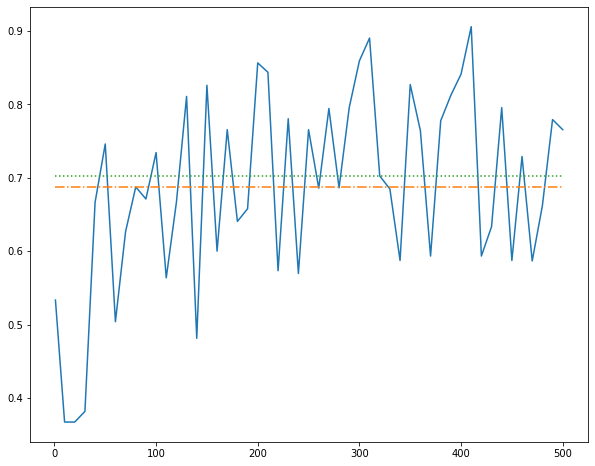

In [79]:
hist_acc = training_loop.history.to_dict()['_values']['eval']['metrics/Accuracy']
hist_f1 = training_loop.history.to_dict()['_values']['eval']['metrics/MacroAveragedFScore']
steps = [t[0] for t in hist_f1]
vals_f1 = [t[1] for t in hist_f1]
vals_acc = [t[1] for t in hist_acc]
import statistics as st
avg_f1 = st.mean(vals_f1)
avg_acc = st.mean(vals_acc)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(steps, vals_f1);
ax.plot(steps, [avg_f1] * len(vals_f1), linestyle="-.")
ax.plot(steps, [avg_acc] * len(vals_acc), linestyle=":")
print(f'>>> Average F1 {avg_f1}')
print(f'>>> Average Accuracy {avg_acc}')

## Testing the model

In [80]:
# Prediction
max_len_text = all_test_tweets.text_clean.map(len).max().item()
max_len_in = all_test_tweets.input_clean.map(len).max().item()

def pad(tweet, max_len):
    return tweet + ([0] * (max_len - len(tweet)))

all_test_tweets['text_clean'] = all_test_tweets.text_clean.apply(pad, args=(max_len_text,))
all_test_tweets['input_clean'] = all_test_tweets.input_clean.apply(pad, args=(max_len_in,))

preds = training_loop.eval_model((np.array(all_test_tweets.text_clean.to_list()), np.array(all_test_tweets.input_clean.to_list())))
target = np.array([pred[1] > pred[0] for pred in preds]).astype(np.integer)
all_test_tweets['target'] = target

/home/atom/work/nlp/nlpenv/lib/python3.8/site-packages/jax/_src/lax/lax.py:4503: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  np_dtype = np.dtype(dtype)
/home/atom/work/nlp/nlpenv/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'numpy.integer'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


In [81]:
# Output
all_test_tweets[['id', 'target']].to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)

In [82]:
# EMBED_MATRIX, WORD_IDX = load_embeds(PROC_EMBED_FILE)

In [83]:
# EMBED_MATRIX[0][0]

In [84]:
# training_loop.model.sublayers[0].sublayers[0].sublayers[0].weights[0]

In [85]:
# help(tl.Embedding)